In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle
from methods import threshold
from methods import find_lane_lines as finder
from methods import curvature_measurement as cm
from methods import draw_lane as dl
from methods import transform_perspective as trp
from methods import warp
from methods import transform_perspective as trp

M = pickle.load(open( "params/perspectiveTransformMatrix.p", "rb" ))
Minv = pickle.load(open( "params/oppositePerspectiveTransformMatrix.p", "rb" ))

dist_pickle = pickle.load( open( "params/calibration.p", "rb" ) )
mtx = dist_pickle[0]
dist = dist_pickle[1]

In [2]:
def show_gray(images):
    for im in images:
        plt.figure()
        plt.imshow(im, cmap='gray')

def show(images):
    for im in images:
        plt.figure()
        plt.imshow(im)

In [3]:
test_images = glob.glob('test_images/*')
images = []
for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    images.append(dst)
    #plt.figure()
    #plt.imshow(dst)
#plt.show()

In [11]:
transformed_images = []
for image in images:
    imshape = image.shape
    trf = trp.transform(image, M)
    transformed_images.append(trf)
    #show_gray([trf])
#plt.show()

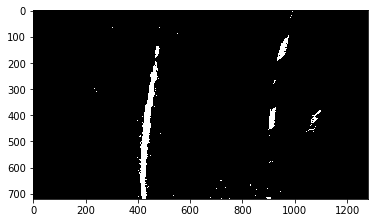

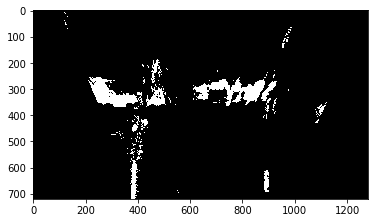

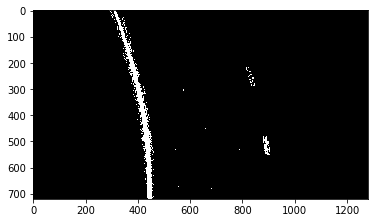

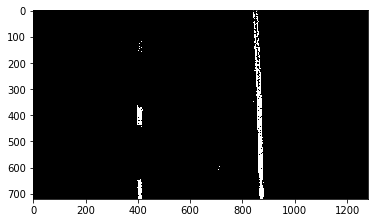

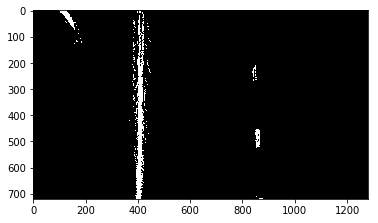

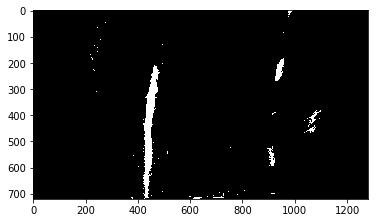

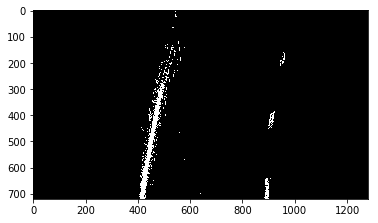

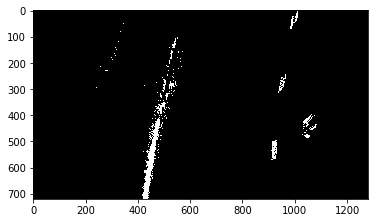

In [12]:
thresholded_images = []
for image in transformed_images:
    thr = threshold.process_image(image)
    thr = warp.process(thr)
    thresholded_images.append(thr)
    show_gray([thr])
plt.show()

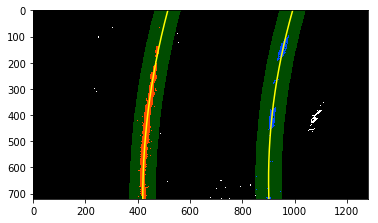

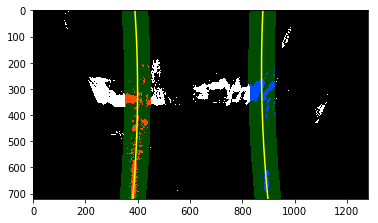

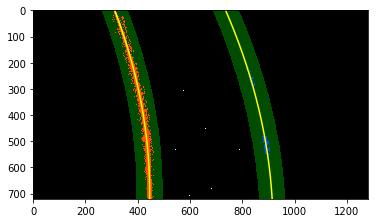

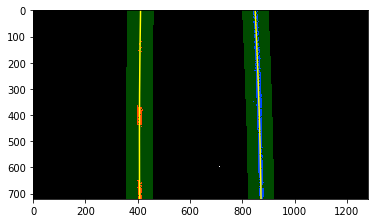

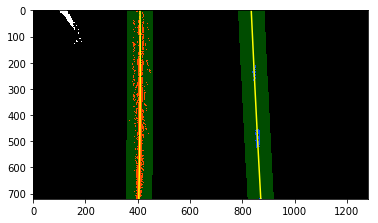

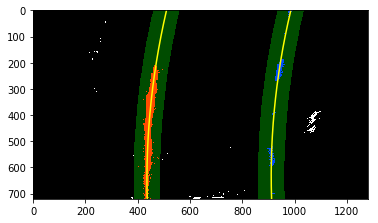

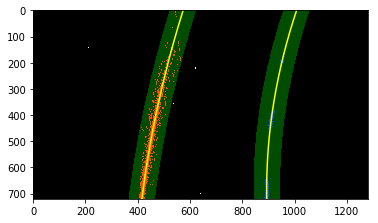

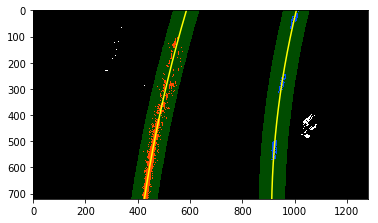

In [13]:
measurements = []
for image in thresholded_images:
    ploty, left_fitx, right_fitx, ret = finder.find(image)
    measurements.append([ploty, left_fitx, right_fitx])
plt.show()

In [18]:
for m in measurements:
    print(m[0], m[1], m[2])
    print(cm.measure(m[0], m[1], m[2]))
    break

[   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.
   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.
   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.
   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.
   96.   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.
  108.  109.  110.  111.  112.  113.  114.  115.  116.  117.  118.  119.
  120.  121.  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.
  132.  133.  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.
  144.  145.  146.  147.  148.  149.  150.  151.  152.  153.  154.  155.
  156.  157.  158.  159.  160.  161.  162.  163.  1

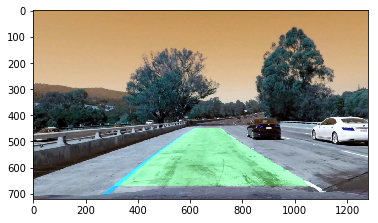

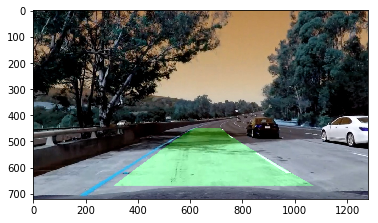

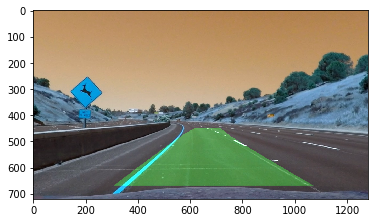

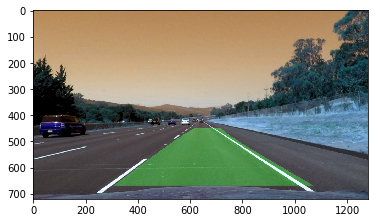

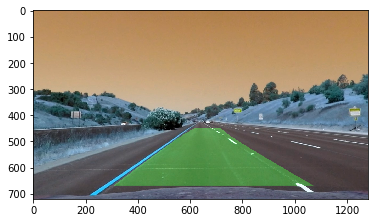

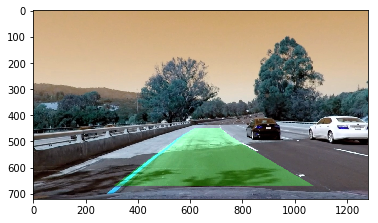

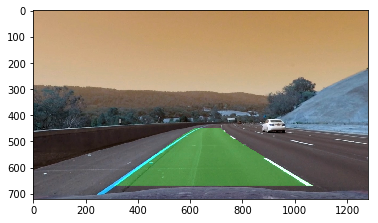

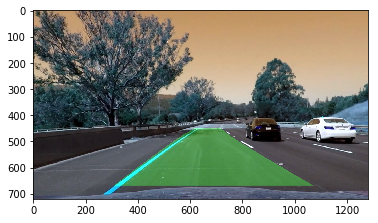

In [16]:
for image, warped in zip(images, thresholded_images):
    m = measurements[i]
    ploty, left_fitx, right_fitx = m[0], m[1], m[2]
    result = dl.draw(image, warped, ploty, left_fitx, right_fitx, Minv)
    show([result])
plt.show()

In [ ]:
def process(image):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    transformed = trp.transform(dst, M)
    thresholded = threshold.process_image(transformed)
    warped = warp.process(thresholded)
    imshape = image.shape
    ploty, left_fitx, right_fitx, ret = finder.find(warped)
    if ret == False:
        return image
    measurements = cm.measure(ploty, left_fitx, right_fitx)
    result = dl.draw(image, warped, ploty, left_fitx, right_fitx, Minv)
    return result

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'videos/out1.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")
#clip1 = VideoFileClip("videos/challenge_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

In [ ]:
'''''
    a = (210,imshape[0]-50)
    b = ((imshape[1]/2)-180, 520)
    c = ((imshape[1]/2)+180, 520)
    d = (imshape[1]-210,imshape[0]-50)
    
    a = (190,imshape[0])
    b = ((imshape[1]/2)-35, 440)
    c = ((imshape[1]/2)+35, 440)
    d = (imshape[1]-160,imshape[0])
'''''

#perspective transform
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

transformed_images = []
for i, image in enumerate(thresholded_images):
    imshape = image.shape
    a = (270,imshape[0]-50)
    b = ((imshape[1]/2)-125, 500)
    c = ((imshape[1]/2)+140, 500)
    d = (imshape[1]-240,imshape[0]-50)
    vertices = np.array([[a, b, c, d]], dtype=np.int32)
    src = np.array([[a, b, c, d]], dtype=np.float32)
    selected = region_of_interest(image, vertices)
    offsetx = 400
    offsety = 0
    dst = np.float32([[offsetx,imshape[0]-offsety], 
                      [offsetx,offsety], 
                      [imshape[1]-offsetx, offsety], 
                      [imshape[1]-offsetx, imshape[0]-offsety]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    transformed_images.append(warped)
    plt.figure()
    plt.imshow(images[i])
    plt.figure()
    plt.imshow(warped, cmap='gray')
    #plt.imshow(selected)
    #break
plt.show()